### Imports

In [11]:
import cv2
import gymnasium as gym
from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.mappings.rewards import RewardsMapping
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

### Testing with random actions

In [4]:
env = gym.make("tetris_gymnasium/Tetris", render_mode="human")

env.reset()

terminated = False
while not terminated:
    env.render()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    key = cv2.waitKey(100) 
env.close()
cv2.destroyAllWindows()

In [17]:
env.close()
cv2.destroyAllWindows()

In [ ]:
def extract_features(obs, env):
    board = obs["board"]

    # 1) Crop to the playable area (20 rows, 10 columns):
    cropped = board[:env.unwrapped.height, env.unwrapped.padding:-env.unwrapped.padding]

    # 2) Compute raw features: column heights, holes, bumpiness, total_height
    heights = []
    holes = 0
    for col_i in range(cropped.shape[1]):
        col = cropped[:, col_i]
        filled_idx = np.where(col > 1)[0]
        if len(filled_idx) == 0:
            h = 0
        else:
            # Height from bottom:
            h = cropped.shape[0] - filled_idx[0]
        heights.append(h)
        if len(filled_idx) > 0:
            holes_col = np.count_nonzero(col[filled_idx[0]:] == 0)
            holes += holes_col

    bumpiness = sum(abs(heights[i] - heights[i+1]) for i in range(len(heights)-1))
    total_height = sum(heights)

    # --- BINNING SECTION ---
    # 1) define thresholds for each feature
    #    e.g. each array of thresholds splits the feature's possible values into
    #    len(thresholds)+1 discrete bins
    height_bins = [4, 8, 12, 16, 20]     # for each column's height
    holes_bins = [2, 5, 10, 15, 20]      # total holes in board
    bumpiness_bins = [5, 10, 15, 20, 25, 30]
    total_height_bins = [20, 40, 60, 80, 100, 120, 140, 160]  

    def bin_value(x, thresholds):
        """Return an integer bin index for x given the threshold array."""
        for i, th in enumerate(thresholds):
            if x < th:
                return i
        return len(thresholds)

    # 2) bin each column's height
    binned_heights = tuple(bin_value(h, height_bins) for h in heights)
    # 3) bin the aggregated features
    holes_bin = bin_value(holes, holes_bins)
    bumpiness_bin = bin_value(bumpiness, bumpiness_bins)
    total_height_bin = bin_value(total_height, total_height_bins)

    return (binned_heights, holes_bin, bumpiness_bin, total_height_bin)

### Sarsa

In [6]:
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # definte the parameters
        self.alpha = alpha 
        self.epsilon = epsilon
        self.gamma = gamma
        self.timeout = timeout

        # environment
        self.env = env

        # define the Q value table
        self.Q = defaultdict(lambda: defaultdict(float))

    def behavior_policy(self, state):

        # explore
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        
        # new state
        if state not in self.Q or not self.Q[state]:
            return self.env.action_space.sample()
        
        # exploit
        return max(self.Q[state], key=self.Q[state].get)
        
    def update(self, s, a, r, s_prime, a_prime):

        # update the Q value table using the SARSA update rule
        self.Q[s][a] += self.alpha * (r + self.gamma * self.Q[s_prime][a_prime] - self.Q[s][a])

    def train(self, num_episodes):

        # initialize rewards
        rewards = []

        # train the agent for a number of episodes
        for episode in range(num_episodes):

            # epsilon decay
            # self.epsilon = max(0.01, self.epsilon * 0.99)

            # reset the environment
            obs, info = self.env.reset()
            state = extract_features(obs, self.env)

            # get the first action
            action = self.behavior_policy(state)

            # initialize the reward
            episode_reward = 0

            for t in range(self.timeout):

                # render the environment
                # self.env.render()
                # key = cv2.waitKey(100)

                # take the action
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                next_state = extract_features(next_obs, self.env)

                # get the next action
                next_action = self.behavior_policy(next_state)

                # update the Q value table
                self.update(state, action, reward, next_state, next_action)

                # update the state, action, and reward
                state = next_state
                action = next_action
                episode_reward += reward

                # if the game is over, reset the environment
                if terminated or truncated:
                    break

            # append the reward to the list of rewards
            rewards.append(episode_reward)

            # print the average reward every 100 episodes
            if episode % 100 == 0:
                avg_reward = np.mean(rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward}")

        return rewards

In [15]:
rewards = RewardsMapping(
    alife=2.0,
    clear_line=1.0,
    game_over=-20.0,
    invalid_action=-0.1,
)

env = gym.make("tetris_gymnasium/Tetris", render_mode="human", rewards_mapping=rewards)
agent = SARSA(env, alpha=0.1, epsilon=0.1, gamma=0.99, timeout=1000)

reward_records = agent.train(num_episodes=100000)

env.close()
cv2.destroyAllWindows()

Episode 0, Average Reward: 0.0
Episode 100, Average Reward: 0.56
Episode 200, Average Reward: 0.56
Episode 300, Average Reward: 0.64
Episode 400, Average Reward: 0.1
Episode 500, Average Reward: 0.0
Episode 600, Average Reward: -0.32
Episode 700, Average Reward: 0.2
Episode 800, Average Reward: 0.28
Episode 900, Average Reward: 0.16
Episode 1000, Average Reward: -0.12
Episode 1100, Average Reward: -0.36
Episode 1200, Average Reward: -0.22
Episode 1300, Average Reward: -0.28
Episode 1400, Average Reward: 0.02
Episode 1500, Average Reward: 0.46
Episode 1600, Average Reward: 0.04
Episode 1700, Average Reward: 0.2
Episode 1800, Average Reward: -0.08
Episode 1900, Average Reward: -0.02
Episode 2000, Average Reward: -0.62
Episode 2100, Average Reward: -0.54
Episode 2200, Average Reward: 0.42
Episode 2300, Average Reward: 0.06
Episode 2400, Average Reward: 0.0
Episode 2500, Average Reward: -0.26
Episode 2600, Average Reward: 0.12
Episode 2700, Average Reward: -0.28
Episode 2800, Average Rewar

KeyboardInterrupt: 

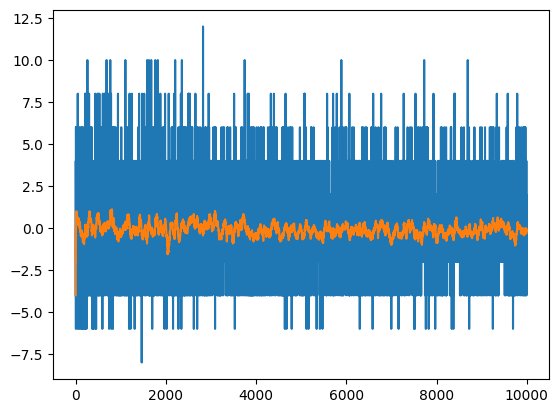

In [ ]:
# FROM CS5180 EXERCISE 7

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)